# train epic seven hero avator recognition network

## define network

In [143]:
import torch
import torch.nn as nn
class Net(nn.Module):
    def __init__(self, class_num):
        super().__init__()
        self.conv1 = nn.Conv2d(3,8,3,2,1)
        self.conv2 = nn.Conv2d(8,16,3,2,1)
        self.conv3 = nn.Conv2d(16,32,3,2,1)
        self.fc = nn.AdaptiveAvgPool2d((1,1))
        self.cls = nn.Linear(32,class_num)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        cls = self.cls(x.reshape(x.shape[0],-1))
        return cls

criterion = nn.CrossEntropyLoss()
    

## test network

In [40]:
net = Net(100)
x = torch.randn(1,3,90,140)
net.eval()
o = net(x)
print(o.shape)
l = criterion(o, torch.tensor([0]).long())
print(l)

torch.Size([1, 100])
tensor(4.3894, grad_fn=<NllLossBackward0>)


## define dataset 

In [7]:
import random
import numpy as np
import imgaug.augmenters as iaa
import torchvision

cut = iaa.Cutout(nb_iterations=1,size=0.1,squared=False)
flip = iaa.Fliplr(0.5)
ty = iaa.TranslateY(px=(-10, 10))

aug = iaa.Sequential([
    flip,
    iaa.Sometimes(0.5,cut),
    iaa.Sometimes(0.5,ty)
])

In [164]:
import os
import cv2

def imread_chinese_path(chinese_path):
    # 使用Python的open读取图片
    with open(chinese_path, 'rb') as fp:
        bytes_io = fp.read()
    image_np = np.frombuffer(bytes_io, np.uint8)
    image = cv2.imdecode(image_np, cv2.IMREAD_COLOR)
    return image
    
class MyDataset():
    def __init__(self, folder， ):
        self.folder = folder
        self.num = len(os.listdir(folder))
        self.filenames = os.listdir(folder)
        self.map_name2id = {}
        self.map_id2name = []
        cnt = 0
        for filename in self.filenames:
            id = filename.split('.')[0].split('_')[0].split(' ')[0]
            if id not in self.map_name2id:
                self.map_name2id[id] = cnt
                self.map_id2name.append(id)
                cnt += 1

        self.transform = aug

    def __len__(self):
        return self.num

    def __getitem__(self, index):
        filename = self.filenames[index]
        id = filename.split('.')[0].split('_')[0].split(' ')[0]
        path = os.path.join(self.folder, filename)
        img = imread_chinese_path(path)
        img = cv2.resize(img, (64,48))
        img = self.transform(image=img)
        img = torchvision.transforms.ToTensor()(img)
        label = self.map_name2id[id]
        return img, label

### test dataset

In [165]:
folder = r"C:\Users\zhouy\source\repos\GameScriptLib\src\app\epic7\assert\photo\3\avatar"
dataset = MyDataset(folder)

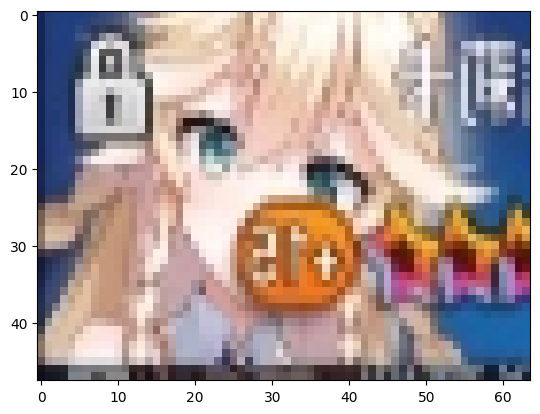

In [166]:
from matplotlib import pyplot as plt
import numpy as np
img, label = dataset[16]
img = (img.numpy().transpose((1,2,0))*255).astype(np.uint8)
plt.imshow(img[:,:,::-1])

In [101]:
dataset.map_id2name[label]

'光水奶'

## 训练网络

In [105]:
torch.cuda.is_available()

True

In [106]:
torch.cuda.set_device(0)

In [167]:
from torch.utils.data import DataLoader as DataLoader
loader = DataLoader(dataset, batch_size = 16, shuffle=True)

In [168]:
net = Net(class_num=len(dataset.map_id2name))
net.cuda()
net.train()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc): AdaptiveAvgPool2d(output_size=(1, 1))
  (cls): Linear(in_features=32, out_features=125, bias=True)
)

In [169]:
from torcheval.metrics import MulticlassAccuracy
metric = MulticlassAccuracy(device="cuda")

In [152]:
## test network inference

In [173]:
net.eval()
img = imread_chinese_path(r"C:\Users\zhouy\source\repos\GameScriptLib\src\app\epic7\assert\photo\3\avatar\木龙.jpg")
input = torchvision.transforms.ToTensor()(img)
input = input.unsqueeze(0).cuda()
out = net(input)

In [174]:
dataset.map_id2name[out[0].argmax().item()]

'木龙'

## pytorch model to onnx

In [176]:
dummy_input = torch.randn(1, 3, 48, 64)

# 4. 使用torch.onnx.export()函数转换模型
torch.onnx.export(net.cpu(), dummy_input, "hero_avatar.onnx")

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### onnx inference

In [178]:
!pip install onnxruntime


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [179]:
import numpy as np
import onnxruntime as ort
import torch
import torchvision.transforms as transforms

In [183]:
img = imread_chinese_path(r"C:\Users\zhouy\source\repos\GameScriptLib\src\app\epic7\assert\photo\3\avatar\木龙.jpg")
img = cv2.resize(img, (64,48))
input = torchvision.transforms.ToTensor()(img)
input = input.unsqueeze(0).numpy()

In [184]:
sess = ort.InferenceSession("hero_avatar.onnx")

In [185]:
inputs = {sess.get_inputs()[0].name: input}
outputs = sess.run(None, inputs)
predicted_class = np.argmax(outputs[0], axis=1)

In [187]:
dataset.map_id2name[predicted_class.item()]

'木龙'